In [5]:
import os
import jax
jax.devices()

[CpuDevice(id=0)]

In [6]:
os.chdir("../../..")
from scripts.nj.neurosci import *
import scripts.nj.graph_to_arrays as ga

## Получаем данные

In [7]:
res = ga.load_jax_context("Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz")

Загрузка контекста из: Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz
   Загружено: 2 групп, 3 массивов ребер, 0 массивов признаков.
Контекст симуляции успешно собран из загруженных данных.


In [8]:
stom = jnp.array(res['stom'])

In [9]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

In [10]:
stom

Array([[10191936,      132],
       [11531426,     1144],
       [12132809,     1481],
       [12927058,     1828],
       [17855652,     5258],
       [ 1805496,     5361],
       [19255911,     5940],
       [ 2662497,     9022],
       [ 4505350,    10191],
       [ 4982132,    10926],
       [ 5018684,    11025],
       [ 7056349,    11455],
       [ 7810915,    11843],
       [ 7843014,    12032],
       [ 8108327,    12470],
       [ 8250193,    12546],
       [ 8824003,    13248],
       [ 8939282,    13386],
       [ 8981142,    13448],
       [ 9011915,    13726]], dtype=int32)

## Определяем структуру симуляции

In [11]:
a, b = '7055857', '1805418'
ind_to_stim = stom[5][1]
ind_to_stim1 = stom[11][1]
def get_my_pipeline(constants, dt = 0.1):

    cable_m = res['edges_cable_to_cable'].T
    pre_syn = res['edges_cable_to_alpha'].T
    post_syn = res['edges_cable_to_alpha'].T
    
    r = jnp.array(res['diam'])/2
    S = np.pi * r**2

    Rm = 10000 # какое у нас Rm?

    L = jnp.array(res['L'])
    ra = jnp.array(res['Ra']) # аксиональное
    rm = Rm/(np.pi * r) # трансмембранное

    lambda_squared = rm/ra
    tau_hh = ra*rm
    #constants['C'] = constants['C']*tau_hh


    HH = get_HH_pipeline(**constants) # получаем функцию для HH
    cable = laplace_at_graph_symetric(cable_m, 'V', scaling = lambda_squared) # получаем функцию для динамики кабелей
    alphaP = get_alpha_synapce_pipeline(pre_syn, post_syn, **constants)
    
    @jax.jit
    def state_transformed(state):
        s, ds = to_diff(state) # создает ds той же формы что и state, но заполненный нулями
        s, ds = alphaP(s, ds)
        s, ds = HH(s, ds) # вставляет HH каналы
        s, ds = cable(s, ds) # соединяет сегменты
        ds['V'] += ds['V'].at[ind_to_stim].add(70*(s['time'] > 10.0)*(s['time'] < 60.0))
        #ds['V'] += ds['V'].at[ind_to_stim1].add(0.7*(s['time'] > 10.0)*(s['time'] < 60.0))
        return s, ds

    integrate = get_runge_kutta_step(state_transformed, dt) # получаем функцию для интегрирования
    @jax.jit
    def my_pipeline(state):
        s = integrate(state) # интегрируем
        return s
    return my_pipeline


### Начальные значения и константы


In [12]:
num_nodes_hh = res['num_nodes']['cable']
num_synapces = res['num_nodes']['alpha']
total_nodes = num_nodes_hh + num_synapces

initials = {
    "V":jnp.ones((num_nodes_hh, ), jnp.float32)*-65.0,
    "m":jnp.ones((num_nodes_hh, ), jnp.float32)*0.0220,
    'n':jnp.ones((num_nodes_hh, ), jnp.float32)*0.0773,
    'h':jnp.ones((num_nodes_hh, ), jnp.float32)*0.9840,
    'alpha':jnp.ones((num_nodes_hh, 2), jnp.float32)*0.0,
    "time":0.0
}

consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 120.0,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 36.0,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.3,     # Проводимость утечки (мСм/см^2),
    "tau":1.0,
    'E_rev':1.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':40.0,
    'synaptic_weights':0.01,
    'G_max':1.0
}

scale = 1500
new_consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54,   # Равновесный потенциал утечки (мВ)
    "gNa": jnp.array(res['gnabar_hh'])*scale,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": jnp.array(res['gkbar_hh'])*scale,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": jnp.array(res['gl_hh'])*scale,     # Проводимость утечки (мСм/см^2),
    "tau":1.25,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.5,
    'synaptic_weights':0.5,
    'G_max':1.0
}

In [13]:
res['gnabar_hh'].shape

(14409,)

In [14]:
np.mean(np.array(res['gnabar_hh'])*scale)

np.float64(54.30067720475854)

In [15]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

## Запуск симуляции

In [16]:
my_pipeline = get_my_pipeline(new_consts, 0.01)

In [17]:
@jax.jit
def output_transform(state):
    return state['time'], state['V'].at[stom[:, 1]].get()

jsim = simulation(initials, my_pipeline, 100, output_transform)
H = jax.block_until_ready(jsim.run(600))

In [18]:
H

(Array([  0.99999934,   1.9999985 ,   2.9999976 ,   3.9999967 ,
          5.0000196 ,   6.0000424 ,   7.0000653 ,   8.000088  ,
          9.000111  ,  10.0001335 ,  11.000156  ,  12.000179  ,
         13.000202  ,  14.000225  ,  15.000248  ,  16.00027   ,
         17.000294  ,  18.000317  ,  19.00034   ,  20.000362  ,
         21.000385  ,  22.000408  ,  23.000431  ,  24.000454  ,
         25.000477  ,  26.0005    ,  27.000523  ,  28.000546  ,
         29.000568  ,  30.000591  ,  31.000614  ,  32.000637  ,
         33.00047   ,  34.0003    ,  35.000134  ,  35.999966  ,
         36.999798  ,  37.99963   ,  38.999462  ,  39.999294  ,
         40.999126  ,  41.99896   ,  42.99879   ,  43.998623  ,
         44.998455  ,  45.998287  ,  46.99812   ,  47.99795   ,
         48.997784  ,  49.997616  ,  50.997448  ,  51.99728   ,
         52.997112  ,  53.996944  ,  54.996777  ,  55.99661   ,
         56.99644   ,  57.996273  ,  58.996105  ,  59.995937  ,
         60.99577   ,  61.9956    ,  62.

## Построение графиков

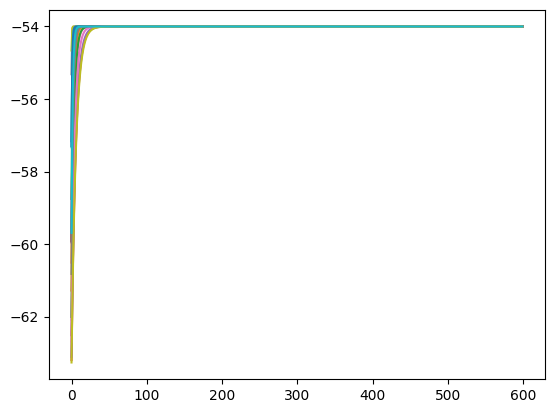

In [19]:
import matplotlib.pyplot as plt
t, v = H
t, v = np.array(t), np.array(v)
plt.plot(v)
plt.show()

- нет четкого соответствия Neuron имплементации
- alpha синапсы вместо exp
- не тот маштаб времени
- не те потенциалы покоя, в общем схожи, нижняя граница совпадает, но не верхняя у меня -55. (точно не из за alpha синапсов) 
- не совпадают стимулы, я подаю ток в 70 мА и ничо не получаю, а должно получатся при 0.7